# پیاده سازی و آموزش شبکه عصبی 

## ملیکا مرافق 810197581



# مقدمه 
 در این پروژه به پیاده سازی شبکه های عصبی چندلایه جهت طبقه بندی تصاویر می پردازیم. 


# توضیح پروژه

<div style="direction:rtl">
ابتدا به پیاده سازی یک شبکه عصبی Feed Forward می پردازیم .سپس شبکه ی عصبی را بر روی داده های Fashion Mnist که شامل تصاویری از 10 لباس مختلف است را آموزش می دهیم.و تاثیر پارامتر ها در فرایند یادگیری بررسی می کنیم.
</div>


In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
TrainData = np.loadtxt(open("D:/هوش/CA/5/Fashion-MNIST/trainData.csv", "rb"), delimiter=",")

In [3]:
TestData = np.loadtxt(open("D:/هوش/CA/5/Fashion-MNIST/testData.csv", "rb"), delimiter=",")

(array([1000.,    0., 1000.,    0., 1000.,    0., 1000.,    0., 1000.,
           0.,    0., 1000.,    0., 1000.,    0., 1000.,    0., 1000.,
           0., 1000.]),
 array([0.  , 0.45, 0.9 , 1.35, 1.8 , 2.25, 2.7 , 3.15, 3.6 , 4.05, 4.5 ,
        4.95, 5.4 , 5.85, 6.3 , 6.75, 7.2 , 7.65, 8.1 , 8.55, 9.  ]),
 <a list of 20 Patch objects>)

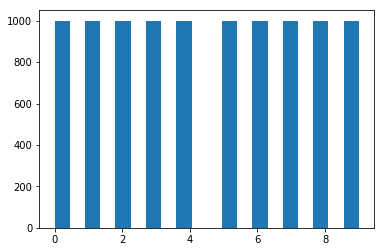

In [8]:
TestLabels = np.loadtxt(open("D:/هوش/CA/5/Fashion-MNIST/testLabels.csv", "rb"), delimiter=",")
TestLabels = TestLabels.astype(int)

plt.hist(TestLabels,bins= 'auto')

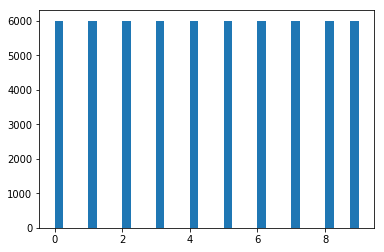

In [4]:
TrainLabels = np.loadtxt(open("D:/هوش/CA/5/Fashion-MNIST/trainLabels.csv", "rb"), delimiter=",")

plt.hist(TrainLabels,bins= 'auto')
TrainLabels = TrainLabels.astype(int)

In [5]:
u, indices = np.unique(TrainLabels, return_index=True)
print(indices,u)

[ 1 16  5  3 19  8 18  6 23  0] [0 1 2 3 4 5 6 7 8 9]


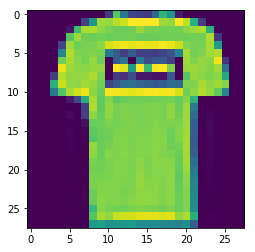

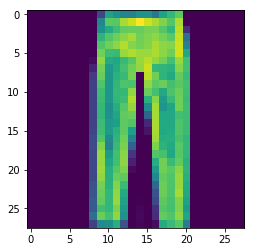

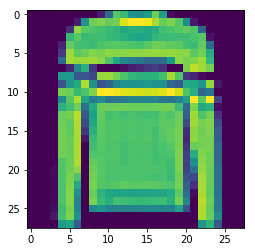

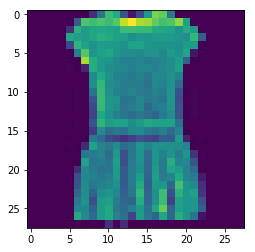

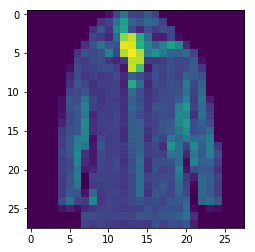

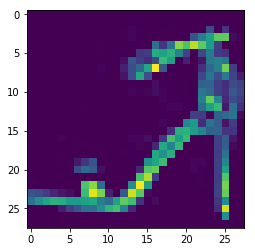

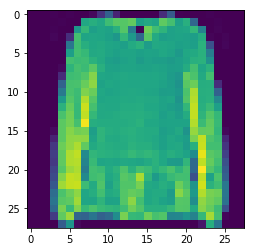

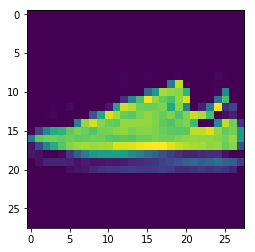

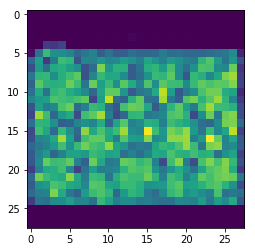

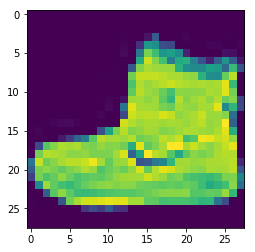

In [6]:
%matplotlib inline 
B = np.reshape(TrainData[16], (-1, 28))
for j in indices:
    B = np.reshape(TrainData[j], (-1, 28))
    plt.imshow(B, interpolation='nearest')
    plt.show()

## Normalize
<div style="direction:rtl">

نرمال سازی دیتا می تواند باعث افزایش فرآیند آموزش و همگرایی سریعتر شود. 
همچنین در صورت عدم نرمال سازی ممکن است overflow رخ دهد.
</div>

In [7]:
TrainData = np.divide(TrainData,255)
TestData = np.divide(TestData,255)

# Dataloader

In [9]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
          
        onehot_vectors = np.eye(n_classes)[labels]
        onehot_vectors = np.matrix(onehot_vectors, copy=False)
        
        return onehot_vectors
    
    def __shuffle_dataset(self):
       
         p = np.random.permutation(len(self.__data))
         self.__data =  self.__data[p]
         self.__onehot_labels = self.__onehot_labels[p]
       
    
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            print(self.__data,self.__onehot_labels)
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

# Activation Functions

In [10]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __relu(self, matrix):
     
        temp = np.matrix(matrix, dtype=float)
        relu_value = np.maximum(0,temp)
        return relu_value

    def derivative(self, matrix):
     
        temp = np.matrix(matrix, dtype=float)
        relu_derivative = (temp > 0) * 1
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__relu(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
      
        temp = np.matrix(matrix, dtype=float)
        leaky_relu_value = np.matrix(np.where(temp > 0, temp, temp * self.negative_slope) , dtype = float)    
        return leaky_relu_value

    def derivative(self, matrix):
 
        temp = np.matrix(matrix, dtype=float)
        leaky_relu_derivative = np.matrix(np.where(temp > 0, 1,self.negative_slope) , dtype = float)  
        return leaky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
       
        temp = np.matrix(matrix, dtype=float)
        sigmoid_value = 1 / (1 + np.exp(-temp))
        return sigmoid_value

    def derivative(self, matrix):
        # TODO: Implement
    
        val = np.array(self.__val(matrix))
        sigmoid_derivative = val * (1 - val)
        sigmoid_derivative =  np.matrix(sigmoid_derivative,dtype = float)
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        # TODO: Implement
     
        exps = np.exp(matrix - np.max(matrix,axis=1))
        stable_softmax =  exps / np.sum(exps , axis=1)
        
        softmax_value = np.matrix(stable_softmax,dtype = float)  
        return softmax_value

    
    def __call__(self, matrix):
        return self.__val(matrix)

# Loss Function

In [12]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val) == np.shape(expected_val)
        # TODO: Implement
     
        pred = Softmax()(true_val)
        temp = -np.multiply(expected_val, np.log(pred + 1e-12))
        cross_entropy_value = np.sum(temp, axis = 1)
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val) == np.shape(expected_val)
       
        softmax = Softmax()
        z = softmax(true_val)
        cross_entropy_derivative = z - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

# Layer

In [13]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'
        
        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None 
        
    def forward(self, layer_input):
        assert np.ndim(layer_input) == 2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        
    
        self.__last_input = layer_input
        self.__last_activation_input = layer_input * self.__weight + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        
        
        dEdY = np.multiply(backprop_tensor, self.__last_activation_derivative)
        backprop_tensor = dEdY * np.transpose(self.__weight)
        dEdW = np.transpose(self.__last_input) * dEdY 
        
        self.__weight = self.__weight - lr * dEdW
        
        matrix = np.matrix(np.ones(dEdY.shape[0]))
        
        dEdb = matrix * dEdY       
        self.__bias = self.__bias - lr * dEdb
        
        return backprop_tensor      

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        
        weights = np.matrix(np.random.uniform(low=low ,high=high, size=(dim1,dim2)) ,dtype = float)
       
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        
        weights = np.matrix(np.random.normal(mean, np.sqrt(var), size=(dim1,dim2)), dtype=  float)  
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

# Feed Forward Neural Network

In [15]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons,n_neurons , activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
     
        
        layer_input = network_input
        for l in self.__layers_list:
            layer_input =  l.forward(layer_input)
            
        network_output = layer_input
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        # TODO: Implement
           
            output = self.forward(x_batch)
            total_error = np.sum(self.__loss(output,y_batch))
            batch_average_loss = total_error / x_batch.size 
            batch_accuracy = self.__compute_accuracy(output,y_batch)
            
            self.__update_weights(output,y_batch)     
            
            return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
   
        
            output = self.forward(x_batch)
            total_error = np.sum(self.__loss(output,y_batch))
            
    
            batch_average_loss = total_error / x_batch.size 
            batch_accuracy = self.__compute_accuracy(output,y_batch)
            return (batch_accuracy, batch_average_loss)        
        
    def __get_labels(self, outputs):
     
        labels = np.argmax(outputs,axis = 1)
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
       
        
        batch_size = output.shape[0]
        corrected = 0
        
        actual = self.__get_labels(expected_output)
        predicted = self.__get_labels(output)
    
        for i in range(batch_size):
            if(predicted.item(i) == actual.item(i)):
                corrected += 1
                
        accuracy = corrected/batch_size * 100
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        
        backprop_tensor = self.__loss.derivative(output,y_train)
        layers = self.__layers_list        
        for layer in reversed(layers):
            backprop_tensor = layer.update_weights(backprop_tensor, self.__lr)
        return 

# Training Sample Code

In [34]:
# Sample code for building and training a model

INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 30 
TRAINLOADER = Dataloader(TrainData,TrainLabels,10,32,True)
TESTLOADER = Dataloader(TestData,TestLabels,10,32,True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(15, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
	Train: Average Accuracy: 45.35	Average Loss: 0.0018037607414840983
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
	Test: Average Accuracy: 71.17611821086263	Average Loss: 0.0010804187835438143
Epoch 2:
[[0.         0.         0.         ... 0.00392157 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.  

	Test: Average Accuracy: 83.1070287539936	Average Loss: 0.0006270766328254593
Epoch 10:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
	Train: Average Accuracy: 86.255	Average Loss: 0.0004842556237324318
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
	Test: Average Accuracy: 83.94568690095846	Average Loss: 0.000568599582672306
Epoch 11:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 

	Test: Average Accuracy: 86.32188498402556	Average Loss: 0.00048412172186096505
Epoch 19:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
	Train: Average Accuracy: 88.36833333333334	Average Loss: 0.00040795418977473074
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
	Test: Average Accuracy: 86.09225239616613	Average Loss: 0.0005069409397043283
Epoch 20:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. 

	Test: Average Accuracy: 86.52156549520767	Average Loss: 0.0005034630264921141
Epoch 28:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
	Train: Average Accuracy: 89.27666666666667	Average Loss: 0.0003748401942507731
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
	Test: Average Accuracy: 86.33186900958466	Average Loss: 0.0004907313910559104
Epoch 29:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.2196

	Train: Average Accuracy: 89.91666666666667	Average Loss: 0.0003522755926696198
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
	Test: Average Accuracy: 86.71126198083067	Average Loss: 0.0004862560348916715
Epoch 38:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
	Train: Average Accuracy: 89.885	Average Loss: 0.0003500243971445991
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 

	Test: Average Accuracy: 86.2320287539936	Average Loss: 0.0005154469165191219
Epoch 46:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
	Train: Average Accuracy: 90.24333333333334	Average Loss: 0.00033517482742358016
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
	Test: Average Accuracy: 86.85103833865814	Average Loss: 0.00048816622334670637
Epoch 47:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. .

	Test: Average Accuracy: 86.69129392971246	Average Loss: 0.0004966110037548077
Epoch 55:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
	Train: Average Accuracy: 90.715	Average Loss: 0.0003218006009904978
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
	Test: Average Accuracy: 86.83107028753993	Average Loss: 0.0004885384764835773
Epoch 56:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]

	Train: Average Accuracy: 90.93666666666667	Average Loss: 0.0003125016672635442
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
	Test: Average Accuracy: 85.58306709265176	Average Loss: 0.0005849258522401766
Epoch 65:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
	Train: Average Accuracy: 90.91333333333333	Average Loss: 0.0003123627462030069
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0

	Train: Average Accuracy: 91.17	Average Loss: 0.0003036955697589886
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
	Test: Average Accuracy: 86.87100638977635	Average Loss: 0.0005058676471661329
Epoch 74:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00392157 0.         ... 0.         0.         0.        ]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0.

	Test: Average Accuracy: 86.84105431309904	Average Loss: 0.0005102559493775774
Epoch 82:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.50196078 0.         0.        ]] [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
	Train: Average Accuracy: 91.40166666666667	Average Loss: 0.00029544078063497886
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]

	Train: Average Accuracy: 91.62	Average Loss: 0.0002889067239945997
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
	Test: Average Accuracy: 87.15055910543131	Average Loss: 0.0005142052508925543
Epoch 91:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00392157 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00784314 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
	Train: Average Accuracy: 91.64166666666667	Average Loss: 0.0002819859731807435
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.36078431 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
	Test: A

## Learning Rate
<div style="direction:rtl">

با کاهش learning rate فرایند آموزش کند می شود یا ممکن است گیر کند و افزایش آن باعث unstable شدن شود و نتواند همگرا شود.  
هنگامیکه learning rate را 0.1 برابر میکنیم فرایند یادگیری به نسبت کند تر می شود و پس از حدود 20 epoch  به دقت 80 درصد می رسد و(در حالت بهینه در epoch 5 به این مقدار می رسید) با 10 برابر کردن(lr =0.01) accuracy حدود 10 درصد می ماند و افزایش پیدا نمی کند و average loss نیز حدود 0.003
</div>


## activation function 
<div style="direction:rtl">
در sigmoid  پس از حدود 25 epoch به دقت حدود 80 درصد رسیدیم (lr = 0.001)و در 10 epoch اول دقت زیر 30 درصد بود.
    
در leaky relue پس از 4 epoch به دقت حدود 80 درصد رسیدیم و در پایان به دقت حدود 86 درصد در داده تست رسیدیم.
    
leaky relu  چون شیب صفر ندارد مشکل "dying ReLU " را ندارد.(اگر یک نورون در ReLU در بخش منفی گیر کند خروجی آن همواره صفر می باشد و همچنین چون شیب نیز در اعداد منفی برابر 0 است احتمال کمی وجود دارد که ازین شرایط خارج شود.این نورون ها بلااستفاده هستند و در نهایت با گذشت زمان بخش زیادی از شبکه کاری انجام نمی دهند. )
نسبت به ReLU بیشتر متوازن است و سریع تر یاد میگیرد. 

از آنجاییکه مقدار خروجی دو تابع tanh , sigmoid کوچکتر از 1 بوده ( مشتق آنها نیز همین طور )در زنجیره ی گرادیان ها برای به روزرسانی وزن ها ،با ضرب گرادیان ها این مقدار کوچک و کوچکترشده و فرآیند آموزش بسیار کند می شود.(vanishing gradients problem)
 </div>

## batch size
<div style="direction:rtl">
    
در صورتی که دیتا ست بسیار بزرگ باشد اگر کل دیتاست را در مموری لود کنیم سرعت آموزش مدل بسیار کم می شود.
همچنین اگر به batch تقسیم نکنیم باید مقادیر خطا را برای کل دیتا ست نگهداری کنیم که مجددا باعث کاهش سرعت آموزش می شود.(در حالیکه با استفاده از batch تنها مقادیر خطا به اندازه سایز batch را باید نگهداری کنیم.
 
اگر سایز batch بسیار کوچک باشد باعث می شود گام هایی که در جهت مینیمم کردن خطا باشند دارای نویز باشند و همچنین همگرایی به مینیمم تابع loss بیشتر طول می کشد.
 </div>

## گام 5
<div style="direction:rtl">
استفاده از یک epoch میتواند باعث underfitting  شود.برای آپدیت کردن وزن ها لازم است چند epoch داشته باشیم تا مدل بهتر train شود.
بعد از حدود 40 epoch هزینه بر روی داده ی تست افزایش یافته و صودی است در حالیکه در داده آموزش هزینه همچنان نزولی است . بنابراین میتوان نتیجه گرفت که بر روی داده آموزشی خیلی خوب fit شده و دچار overfitting می شویم .همچنین دقت پس از حدود 40 epoch در داده آموزشی به بیش از 90 درصد رسیده در حالیکه در داده تست تقریبا ثابت مانده است. 
    
</div>

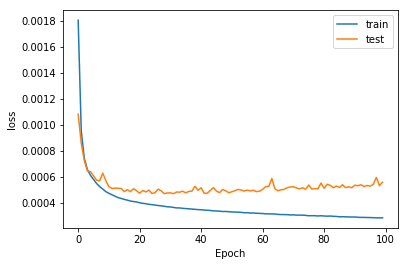

In [35]:
plt.plot(log['train_loss'],label = 'train')
plt.plot(log['test_loss'],label='test')
plt.legend(loc = "upper right")
plt.xlabel('Epoch')
plt.ylabel('loss')

plt.show()

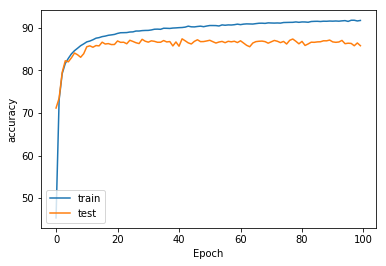

In [37]:
plt.plot(log['train_accuracy'],label = 'train')
plt.plot(log['test_accuracy'],label='test')
plt.legend(loc = "lower left")
plt.xlabel('Epoch')
plt.ylabel('accuracy')

plt.show()